<center><font size = "10"> Week 11 - Network Simulation II<center>
<center><font size = "8">Tutorial 01: Spike train analysis 01 <center>

<font size='3'><font color='blue'> In this tutorial we will analyze the spike trains from the different cells.
    
<font size='3'><font color='blue'> We will stimulate each cell with a stimulus that has the same __mean frequency__ but a small __jitter__.   
    
<font size='3'><font color='blue'>Then we will compute statistics on each spike train and we will compute a crosscorrelation analysis between spike trains using [ELEPHANT](https://elephant.readthedocs.io/en/latest/index.html), a library for the analysis of electrophysiological data in Python.

In [1]:
import elephant.spike_train_generation as elstg

/usr/local/lib/python3.6/dist-packages/elephant/pandas_bridge.py:22: DeprecationWarning: pandas_bridge module will be removed in Elephant v0.8.x
  DeprecationWarning)


### Compile the MOD files necesary for the simulation

In [2]:
!nrnivmodl

/home/in_silico/InSilicoClass/my_notebooks/week11
vecevent.mod
vecevent.mod
"/usr/local/nrn/share/nrn/libtool" --tag=CC --mode=compile gcc -DHAVE_CONFIG_H  -I. -I.. -I"/usr/local/nrn/include/nrn" -I"/usr/local/nrn/x86_64/lib"      -g -O2 -c -o mod_func.lo mod_func.c
libtool: compile:  gcc -DHAVE_CONFIG_H -I. -I.. -I/usr/local/nrn/include/nrn -I/usr/local/nrn/x86_64/lib -g -O2 -c mod_func.c  -fPIC -DPIC -o .libs/mod_func.o
"/usr/local/nrn/share/nrn/libtool" --tag=CC --mode=link gcc -module  -g -O2    -o libnrnmech.la -rpath "/usr/local/nrn/x86_64/lib"  vecevent.lo mod_func.lo  -L"/usr/local/nrn/x86_64/lib" -lnrnoc -loc -lmemacs  -lscopmath -lsparse13 -lreadline -lncurses -ltinfo -L"/usr/local/nrn/x86_64/lib" -lnrniv -livoc -lneuron_gnu -lmeschach -lsundials       -lm -ldl
libtool: link: rm -fr  .libs/libnrnmech.la .libs/libnrnmech.lai .libs/libnrnmech.so .libs/libnrnmech.so.0 .libs/libnrnmech.so.0.0.0
libtool: link: gcc -shared  -fPIC -DPIC  .libs/vecevent.o .libs/mod_func.o   -Wl,-rpat

### Load useful packages

In [3]:
%matplotlib inline

from neuron import h, gui
import matplotlib.pyplot as plt
import numpy as np

# Load external files & initialize
h.load_file("stdrun.hoc");
h.stdinit();

### Define the class Cell

In [4]:
class Cell:
    def __init__(self, filename, name, cell_type):
        self.name = name
        self.type = cell_type
        self.synapses = []
        self.build_morphology(filename)
        self.biophysics()
        
    def build_morphology(self, filename):
        h.load_file('import3d.hoc')
        h.load_file('stdlib.hoc')
        #morph_reader = h.Import3d_Neurolucida3()
        morph_reader = h.Import3d_SWC_read()
        morph_reader.input(filename)
        i3d = h.Import3d_GUI(morph_reader, 0)
        i3d.instantiate(self) # Notice this change to be able to instantiate several cells
    
    def biophysics(self):
        for sec in h.allsec():
            sec.Ra = 100    # Axial resistance in Ohm * cm
            sec.cm = 1      # Membrane capacitance in micro Farads / cm^2
            sec.insert("pas")
            for seg in sec:
                seg.pas.g = 0.00003
                seg.pas.e = -75
        
        # Insert passive current in the dendrite
        for sec in self.soma:
            sec.insert('hh')
            for seg in sec:
                seg.hh.gnabar = 0.12  # Sodium conductance in S/cm2
                seg.hh.gkbar = 0.036  # Potassium conductance in S/cm2
        
        if hasattr(self, 'apic'):
            for sec in self.apic:
                sec.insert('hh')
                for seg in sec:
                    seg.hh.gnabar = 0.12  # Sodium conductance in S/cm2
                    seg.hh.gkbar = 0.036  # Potassium conductance in S/cm2
        
        for sec in self.dend:
            sec.insert('hh')
            for seg in sec:
                seg.hh.gnabar = 0.12  # Sodium conductance in S/cm2
                seg.hh.gkbar = 0.036  # Potassium conductance in S/cm2
                
        for sec in self.axon:
            sec.insert('hh')
            for seg in sec:    
                seg.hh.gnabar = 0.12  # Sodium conductance in S/cm2
                seg.hh.gkbar = 0.036  # Potassium conductance in S/cm2

### Load the morphologies to work with

<font size='3'> Running the next cell will result in an error message due to the morphology file, but don't pay attention to it, you will be able to run the simulations on these morphologies

In [5]:
Pyr1 = Cell('Pyr_01.swc','Pyr1','Pyr')
Pyr2 = Cell('Pyr_02.swc','Pyr2','Pyr')
Int1 = Cell('Int_01.swc','Int1','Int')
cells_Pyr = [Pyr1, Pyr2]
cells_Int = [Int1]
cells = cells_Pyr + cells_Int

error Pyr_01.swc line 12052: could not parse: 
error Pyr_02.swc line 12344: could not parse: 
error Int_01.swc line 11322: could not parse: 


### Check the number of sections

In [6]:
for c in cells_Pyr:
    print('%s: %d apical sections, %d basal sections, %d soma sections and %d axon senctions' % (c.name,len(c.apic),len(c.dend), len(c.soma), len(c.axon)))
for c in cells_Int:
    print('%s: %d basal sections, %d soma sections and %d axon senctions' % (c.name,len(c.dend), len(c.soma), len(c.axon)))

Pyr1: 13 apical sections, 34 basal sections, 2 soma sections and 169 axon senctions
Pyr2: 115 apical sections, 61 basal sections, 2 soma sections and 170 axon senctions
Int1: 21 basal sections, 2 soma sections and 526 axon senctions


### Connect cells

In [7]:
# connect two cells with an exponential synapse at given locations
# returns the netcon
def connect(source, target, weight = None, delay = 5, source_sec = None, source_neurite = 'axon', target_sec = None, target_neurite = 'dend', rng = None, seed = None):
    if rng is None:
        rng = np.random.default_rng(seed)
    
    if weight is None:
        weight = rng.uniform() # random weight
    
    target_neurite_ = getattr(target, target_neurite)
    if target_sec is None:
        target_sec = rng.integers(0, len(target_neurite_)) # random dendritic section
    
    source_neurite_ = getattr(source, source_neurite)
    if source_sec is None:
        source_sec = rng.integers(0, len(source_neurite_)) # random axonal section
    
    target_syn = h.ExpSyn(target_neurite_[target_sec](0.5))
    target.synapses.append(target_syn) # store synapse
    
    netcon = h.NetCon(source_neurite_[source_sec](0.5)._ref_v, target_syn, sec=source_neurite_[source_sec])
    netcon.weight[0] = weight
    netcon.delay = delay
    
    print('Connected cells %s::%s[%d] -> %s::%s[%d] with weight %g and delay %g' % (source.name,source_neurite,source_sec,target.name,target_neurite,target_sec,weight,delay))
    return netcon

In [8]:
netcons = [] # save the netcons in case we want to modify them later

seed = 1234 # specify seed for replicability of all that follows
rng = np.random.default_rng(seed)

# Connect Pyr2 and Int1 to Pyr1
nc = connect(Pyr2,Pyr1,rng = rng,weight = 0.1)
netcons.append(nc)
nc = connect(Int1,Pyr1,rng = rng,weight = 0.1,target_neurite='soma')
netcons.append(nc)

# Connect Pyr1 and Int1 to Pyr2
nc = connect(Pyr1,Pyr2,rng = rng,weight = 0.1)
netcons.append(nc)
nc = connect(Int1,Pyr2,rng = rng,weight = 0.1,target_neurite='soma')
netcons.append(nc)

# Connect Pyr1 and Pyr2 to Int1
nc = connect(Pyr1,Int1,rng = rng,weight = 0.1)
netcons.append(nc)
nc = connect(Pyr2,Int1,rng = rng,weight = 0.1)
netcons.append(nc)

Connected cells Pyr2::axon[166] -> Pyr1::dend[33] with weight 0.1 and delay 5
Connected cells Int1::axon[199] -> Pyr1::soma[1] with weight 0.1 and delay 5
Connected cells Pyr1::axon[156] -> Pyr2::dend[10] with weight 0.1 and delay 5
Connected cells Int1::axon[137] -> Pyr2::soma[0] with weight 0.1 and delay 5
Connected cells Pyr1::axon[53] -> Int1::dend[2] with weight 0.1 and delay 5
Connected cells Pyr2::axon[20] -> Int1::dend[11] with weight 0.1 and delay 5


### Add synapses

In [9]:
# Place exponential synapses in random cell sections

# Exponential synapses
synapses = []
for cell in cells:
    sec = rng.integers(0, len(cell.dend))
    syn = h.ExpSyn(cell.dend[sec](0.5))
    syn.tau = 2 # ms
    print('ExpSyn created at %s::%s[%s] with tau = %g' % (cell.name,"dend",sec,syn.tau))
    synapses.append(syn)

ExpSyn created at Pyr1::dend[27] with tau = 2
ExpSyn created at Pyr2::dend[14] with tau = 2
ExpSyn created at Int1::dend[16] with tau = 2


### Setup stimulator per cell

In [10]:
# Create stimulators for synapses
stims = []
stim_nc = []
for syn in synapses:
    stim = h.VecStim()
    nc = h.NetCon(stim, syn)
    nc.weight[0] = 0.5 # In units of [nS] due to the gmax scaling factor in our .mod file
    stims.append(stim)
    stim_nc.append(nc)

### Setup stimulation times: same frequency + jitter

In [11]:
import quantities as pq

In [12]:
# Expects freq in Hz, t_start in ms, t_stop in ms
def regular_jitter_spikes(freq, t_start, t_stop):
    period = 1000 / freq # period in ms
    st = np.arange(float(t_start),float(t_stop),float(period))
    rng = np.random.default_rng()
    jitter = rng.normal(size=len(st))
    return st + jitter

# Create a regular (+jitter) spike train
stim_rate = 70 * pq.Hz
stim_tstart = 5 * pq.ms
stim_tstop = 300 * pq.ms

stim_times = []
for stim in stims:
    sptimes = regular_jitter_spikes(stim_rate, stim_tstart, stim_tstop)
    spvec = h.Vector(sptimes)
    stim.play(spvec) # make stimulator fire at these times
    stim_times.append(sptimes)
    print(sptimes)

[  6.7188011   19.88663954  33.73825809  48.00631862  63.95166977
  76.22494041  91.20346899 104.98627089 118.31912462 134.09885742
 147.16395023 161.65035965 176.62701112 190.64244527 205.24843978
 220.24106044 232.57895172 248.56099297 261.44807992 275.42189407
 291.74993043]
[  5.14576041  20.07549818  34.5235847   45.6148471   62.97659632
  75.20503108  90.64224025 104.89034467 117.88767626 133.80812636
 149.10319983 162.74030759 177.18105255 191.44905401 203.86845312
 217.99037656 234.87758045 246.10251299 262.94178033 275.55576109
 289.53513116]
[  6.54539531  18.90786683  34.49599953  48.4187678   60.93511657
  76.81471579  91.7537216  105.92031146 120.55542979 132.68535521
 148.61057134 161.79166258 177.34106703 189.75903961 204.47825721
 218.05714364 232.16869758 247.56124118 264.27846034 277.19301542
 291.53914371]


### Run simulation

In [13]:
recording_cells = [Pyr1, Pyr2, Int1]

somaV = []
for cell in recording_cells:
    s = h.Vector().record(cell.soma[0](0.5)._ref_v)
    somaV.append(s)

time = h.Vector().record(h._ref_t)
sim_tstop = 300

h.finitialize(-65)
h.continuerun(sim_tstop)

0.0

### Plot voltage traces

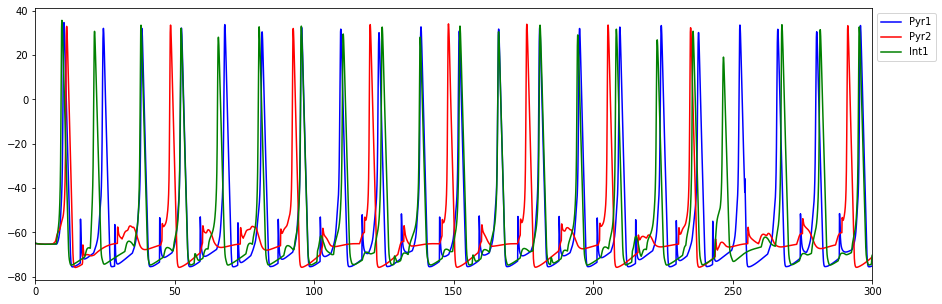

In [21]:
colors = ['blue', 'red', 'green']

fig, ax = plt.subplots(figsize=(15,5))
for cell,V,color in zip(recording_cells,somaV,colors):
    ax.plot(time, V, label=cell.name, color=color)

ax.set_xlim((0,sim_tstop))
ax.legend(bbox_to_anchor=(1, 1))
plt.show()

### Spike detection

In [15]:
from neo import AnalogSignal

def spike_detector(voltage, threshold):
    # convert Neuron recording (voltage) to neo.AnalogSignal
    sig = AnalogSignal(voltage,units = pq.mV,sampling_period = 0.025 * pq.ms) # dt = 0.025 ms
    # peak locations
    spike_time = elstg.peak_detection(sig,threshold = threshold * pq.mV,format = 'raw')
    return spike_time * 1000 # in ms

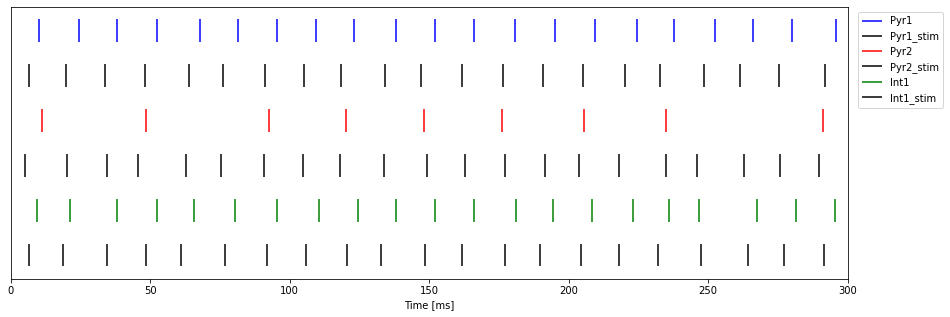

In [16]:
spike_trains = []
for V,st in zip(somaV,stim_times):
    spk = spike_detector(V, -20.0) # tune threshold as needed
    spike_trains.append(spk) # add cell spikes
    spike_trains.append(st)  # add stim spikes
    
name_lst = [[_.name,_.name + '_stim'] for _ in recording_cells]
name_lst = [x for sub in name_lst for x in sub] # https://stackoverflow.com/a/952952

colors = ['blue', 'black', 'red', 'black', 'green', 'black']

fig, ax = plt.subplots(figsize=(15,5))
for (i,name),spikes,color in zip(enumerate(name_lst),spike_trains,colors):
    ymin = 2 * i * -0.1
    ymax = 2 * i * -0.1 - 0.1
    ax.vlines(spikes, ymin=ymin, ymax=ymax, color=color, label=name)

ax.set_xlim((0,sim_tstop))
ax.set_xlabel("Time [ms]")
ax.set_yticks([])

# Put a legend below current axis
ax.legend(bbox_to_anchor=(1.12, 1))

plt.show()

## 1. Single Spike train statistics

In [17]:
import elephant.statistics as elstat

for x,s in zip(name_lst,spike_trains):
    print(x)
    fr = elstat.mean_firing_rate(s) * 1000
    print('Mean firing rate = %g Hz' % fr)
    # Inter-spike intervals
    isi = elstat.isi(s)
    cv = elstat.cv(isi)
    print('CV of ISI = %g' % cv)

Pyr1
Mean firing rate = 70.9939 Hz
CV of ISI = 0.0453688
Pyr1_stim
Mean firing rate = 71.9795 Hz
CV of ISI = 0.0825349
Pyr2
Mean firing rate = 30.8986 Hz
CV of ISI = 0.277692
Pyr2_stim
Mean firing rate = 72.5301 Hz
CV of ISI = 0.122245
Int1
Mean firing rate = 71.0961 Hz
CV of ISI = 0.13551
Int1_stim
Mean firing rate = 72.0315 Hz
CV of ISI = 0.0929877


## 2. Correlation analysis between spike trains

In [18]:
from neo import SpikeTrain
from elephant.conversion import BinnedSpikeTrain
import elephant.spike_train_correlation as elstc

### Pairwise correlation histograms

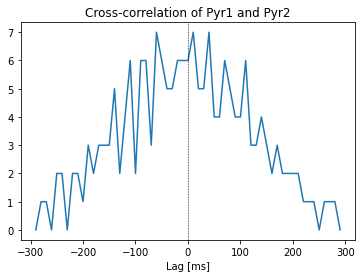

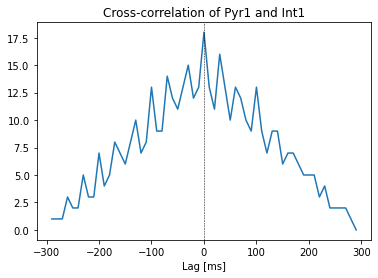

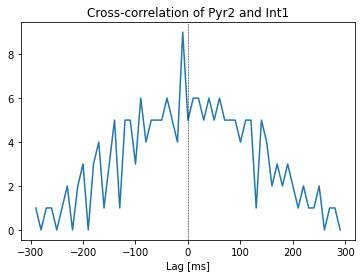

In [19]:
import itertools

# Pick only cell spike trains (saved in even entries of spike_trains)
cell_names = [x for i,x in enumerate(name_lst) if i % 2 == 0]
cell_spikes = [x for i,x in enumerate(spike_trains) if i % 2 == 0]

binsize = 10 * pq.ms # 10 ms bin
allspikes = [SpikeTrain(x * pq.ms, t_stop = sim_tstop * pq.ms) for x in cell_spikes]
binned_spikes = [BinnedSpikeTrain(x, binsize = binsize) for x in allspikes]

for a,b in itertools.combinations(zip(cell_names,binned_spikes), 2):
    cch, lags = elstc.cross_correlation_histogram(a[1],b[1],border_correction=False)
    fig, ax = plt.subplots()
    ax.set_title("Cross-correlation of {} and {}".format(a[0],b[0]))
    ax.set_xlabel("Lag [ms]")
    plt.plot(lags * binsize,cch)
    plt.axvline(0,ls='--',color='black',lw=0.5)

### Pairwise correlation coefficients

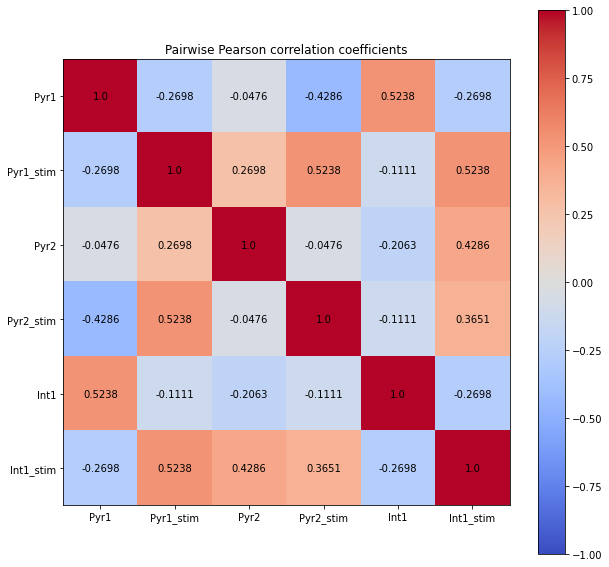

In [20]:
# We bin the spikes in both cell and stim spikes
allspikes = [SpikeTrain(x * pq.ms, t_stop = sim_tstop * pq.ms) for x in spike_trains]
binned_spikes = BinnedSpikeTrain(allspikes, binsize = 10 * pq.ms) # 10 ms bin
# Correlation coefficient matrix between all spike trains
cc = elstc.corrcoef(binned_spikes)

fig, ax = plt.subplots(figsize=(10,10))
im = ax.imshow(cc, cmap="coolwarm", vmin=-1.0, vmax=1.0, origin = 'upper')

# We want to show all ticks...
ax.set_xticks(np.arange(len(name_lst)))
ax.set_yticks(np.arange(len(name_lst)))
# ... and label them with the respective list entries
ax.set_xticklabels(name_lst)
ax.set_yticklabels(name_lst)

# Loop over data dimensions and create text annotations.
for i in range(len(name_lst)):
    for j in range(len(name_lst)):
        text = ax.text(j, i, np.round(cc[i, j],4),
                       ha="center", va="center", color="black")

ax.set_title('Pairwise Pearson correlation coefficients')
plt.colorbar(im)
plt.show()